In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import os
import matplotlib.pyplot as plt

INTERVAL = 10
INTERVAL_SQUARED = INTERVAL**2
NUM_BINS = INTERVAL**3+INTERVAL**2+INTERVAL+1


def convert_rgb_tensor_to_key(tensor_data):
    scaled_data = (tensor_data*INTERVAL).to(torch.long)
    bucket = scaled_data[:,0]*INTERVAL_SQUARED+scaled_data[:,1]*INTERVAL+scaled_data[:,2]
    return bucket

class WeightedMSELoss(nn.MSELoss):
    
    def __init__(self, value_embedding_layer):
        super().__init__(reduction="none")
        self.value_embedding_layer = value_embedding_layer

        
    def forward(self, input, target):
        mse_loss = super().forward(input, target)
        bucket = convert_rgb_tensor_to_key(target)
        value_embeddings = self.value_embedding_layer(bucket).squeeze()
        mse_loss = torch.mean(mse_loss, dim=1)
        weighted_mse_loss = (mse_loss * value_embeddings).mean()
        return weighted_mse_loss

In [2]:
!pip install ptlflow -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.2 requires cubinlinker, which is not installed.
cudf 24.8.2 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.2 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.2 requires cupy-cuda11x>=12.0.0, which is not installed.
aiobotocore 2.13.2 requires botocore<1.34.132,>=1.34.70, but you have botocore 1.29.165 which is incompatible.
albumentations 1.4.14 requires pydantic>=2.7.0, but you have pydantic 1.10.18 which is incompatible.
beatrix-jupyterlab 2024.66.154055 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-clo

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
from torchvision import transforms
from pathlib import Path
from PIL import Image
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
# from torchsummary import summary
from kornia import color

/opt/conda/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [4]:
class Places365Train(Dataset):
    def __init__(self, root: Path):
        self.data_dir = root
        self.data_paths = sorted(list(self.data_dir.rglob("*.jpg")))

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Read an image and convert it to black and white and lab color space.

        Args:
            idx (int): Image index

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Black and white image and lab color space image
        """
        with Image.open(self.data_paths[idx]) as img:
            rgb_img = transforms.ToTensor()(img.convert("RGB"))  # (3, 256, 256)
            bw_img = transforms.ToTensor()(img.convert("L"))  # (1, 256, 256)
            bw_img = bw_img.repeat(3, 1, 1)  # (3, 256, 256)

        lab_img = color.rgb_to_lab(rgb_img)  # (3, 256, 256) -> L, a, b
        lab_img[0] = lab_img[0] / 100  # L channel
        lab_img[1:] = lab_img[1:] / 128  # a, b channel

        return bw_img, rgb_img

    @staticmethod
    def lab_to_rgb(lab_img: torch.Tensor) -> torch.Tensor:
        return lab_img
        """Convert lab image to rgb image.

        Args:
            lab_img (torch.Tensor): Lab color space image

        Returns:
            torch.Tensor: RGB image
        """
        lab_img[0] = lab_img[0] * 100  # L channel
        lab_img[1:] = (lab_img[1:] * 255) - 128  # a, b channel
        rgb_img = color.lab_to_rgb(lab_img)
        return rgb_img
    
frames_dataset = Places365Train(Path("/kaggle/input/davis-2017-trainval/DAVIS_resized"))

In [5]:
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class VideoFramesDataset(Dataset):
    def __init__(self, root: Path):
        self.data_dir = root
        self.data_paths = sorted(list(self.data_dir.rglob("*.jpg")))

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Return the current black and white image, previous black and white image, and current color image."""
        
        # Load current image
        with Image.open(self.data_paths[idx]) as img:
            rgb_img = transforms.ToTensor()(img.convert("RGB"))  # (3, 256, 256)
            bw_img = transforms.ToTensor()(img.convert("L"))  # (1, 256, 256)
            bw_img = bw_img.repeat(3, 1, 1)  # (3, 256, 256)
        
        # Check if the current image is the first frame of a video by comparing directories
        if idx == 0 or self.data_paths[idx].parent != self.data_paths[idx-1].parent:
            # If the current image is the first frame, set the previous frame to the current frame
            prev_bw_img = bw_img
            prev_rgb_img = rgb_img
        else:
            # Load the previous frame
            with Image.open(self.data_paths[idx-1]) as img:
                prev_bw_img = transforms.ToTensor()(img.convert("L"))  # (1, 256, 256)
                prev_bw_img = prev_bw_img.repeat(3, 1, 1)  # (3, 256, 256)
                prev_rgb_img = transforms.ToTensor()(img.convert("RGB"))

        return prev_bw_img, bw_img, prev_rgb_img, rgb_img
    
from torch.utils.data import DataLoader

directory = "/kaggle/input/davis-2017-trainval/DAVIS_resized/"
vid_directory = '/kaggle/input/davis-2017-test-dev/DAVIS_resized/'

# Initialize the dataset
dataset = VideoFramesDataset(Path(directory))
vid_dataset = VideoFramesDataset(Path(vid_directory))
len(dataset), len(vid_dataset)

(6208, 2086)

In [6]:
import torch
from torch.utils.data import random_split

train_ratio = 0.8
test_ratio = 0.2  
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

train_set, val_set = random_split(dataset, [train_size, test_size])

len(train_set), len(val_set)

(4966, 1242)

In [7]:
occurrence = torch.zeros(NUM_BINS)
for data in tqdm(frames_dataset):
    rgb_image = data[1]
    key = convert_rgb_tensor_to_key(rgb_image).view(-1)
    bin_counts = torch.bincount(key, minlength = NUM_BINS)
    occurrence += bin_counts

100%|██████████| 6208/6208 [01:23<00:00, 74.05it/s]


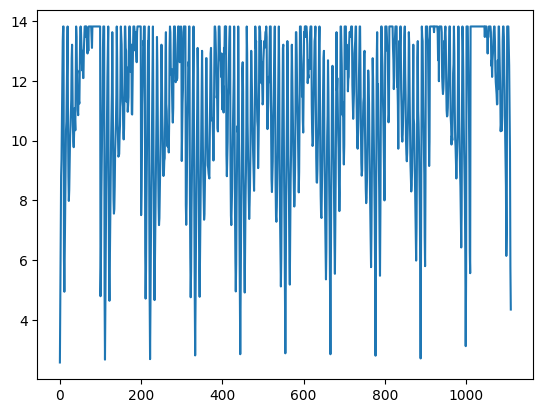

In [8]:
import matplotlib.pyplot as plt

probabilities = (occurrence/torch.sum(occurrence)).view(-1)
probabilities = -torch.log(probabilities+1e-6).view(-1,1)
plt.plot(probabilities.view(-1))

In [9]:
value_embedding = nn.Embedding(num_embeddings=NUM_BINS, embedding_dim=1) 
value_embedding.weight.data = probabilities
value_embedding = value_embedding.to("cuda")

In [10]:
class Block(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, upsample=1):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.Tanh()  # todo: change to ReLU
        self.upsample = torch.nn.Upsample(scale_factor=upsample)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.upsample(self.relu(self.bn(self.conv(x))))

In [11]:
class ConvNetWithEfficientNetFeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.FEATURE_EXTRACTOR_LAYERS = 9
        self.feature_extractor = efficientnet_b7(
            weights=EfficientNet_B7_Weights.IMAGENET1K_V1
        ).features
        # *****************
        self.feature_extractor[0][0] = nn.Conv2d(6, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # *****************
        self.feature_extractor.requires_grad_(False)

        self.colorization_layers = torch.nn.Sequential(
            Block(2560, 640),
            Block(640, 384),
            Block(384, 224, upsample=2),
            Block(224, 160),
            Block(160, 80, upsample=2),
            Block(80, 48, upsample=2),
            Block(48, 32, upsample=2),
            Block(32, 64, upsample=2),
            torch.nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            torch.nn.Sigmoid(),
        )
        self.quantized = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feature32 = self.feature_extractor[0:2](
            x
        )  # 3x256x256 -> 64x128x128 -> 32x128x128
        feature48 = self.feature_extractor[2](feature32)  # 32x128x128 -> 48x64x64
        feature80 = self.feature_extractor[3](feature48)  # 48x64x64 -> 80x32x32
        feature224 = self.feature_extractor[4:6](
            feature80
        )  # 80x32x32 -> 160x16x16 -> 224x16x16
        feature640 = self.feature_extractor[6:8](
            feature224
        )  # 224x16x16 -> 384x8x8 -> 640x8x8
        feature2560 = self.feature_extractor[8](feature640)  # 640x8x8 -> 2560x8x8
        
        if not self.quantized:
            out = self.colorization_layers[0](feature2560)  # 2560x8x8 -> 640x16x16
            out += feature640
            out = self.colorization_layers[1:3](out)  # 640x16x16 -> 384x32x32 -> 224x32x32
            out += feature224
            out = self.colorization_layers[3:5](out)  # 224x32x32 -> 160x64x64 -> 80x64x64
            out += feature80
            out = self.colorization_layers[5](out)  # 80x64x64 -> 48x128x128
            out += feature48
            out = self.colorization_layers[6](out)  # 48x128x128 -> 32x256x256
            out += feature32
            out = self.colorization_layers[7:10](
                out
            )  # 32x256x256 -> 64x256x256 -> 2x256x256
        else:
            out = self.colorization_layers[0](feature2560)  # 2560x8x8 -> 640x16x16
            out += feature640
            out = self.colorization_layers[1](out)  # 640x16x16 -> 384x32x32 -> 224x32x32
            out += feature224
            out = self.colorization_layers[2](out)  # 224x32x32 -> 160x64x64 -> 80x64x64
            out += feature80
            out = self.colorization_layers[3](out)  # 80x64x64 -> 48x128x128
            out += feature48
            out = self.colorization_layers[4](out)  # 48x128x128 -> 32x256x256
            out += feature32
            out = self.colorization_layers[5](out)  # 32x256x256 -> 64x256x256 -> 2x256x256
        return out

    def convert_output_to_rgb(
        self, x: torch.Tensor, output: torch.Tensor
    ) -> torch.Tensor:

        return output
        lab_img = x.clone()
        lab_img[1:] = output
        return Places365Train.lab_to_rgb(lab_img)

In [12]:
def prep_output(output, input):
    input_l = input[:, 0:1, :, :]
    output_ab = output[:, 1:3, :, :]
    return torch.cat((input_l, output_ab), dim=1)

In [13]:
from torch.optim import AdamW
from torch.nn import MSELoss
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNetWithEfficientNetFeatureExtractor().to(device)
optimizer = AdamW(model.parameters(), lr=1e-3)
mseloss = MSELoss()
weighted_mseloss = WeightedMSELoss(value_embedding)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:03<00:00, 70.2MB/s] 


In [14]:
import torchvision
import torchvision.models as models

# Load the pre-trained VGG11 model
vgg11 = models.vgg11(pretrained=True)

vgg11.features[-1]=torch.nn.Identity()
vgg11 = vgg11.features

for param in vgg11.parameters():
    param.requires_grad = False
    
vgg11 = vgg11.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:11<00:00, 44.9MB/s] 


In [15]:
import torch.nn.functional as F
import cv2
import ptlflow

OCCLUSION_MASK_INCONSISTENCY_THRESHOLD = 0.75

class TemporalConsistencyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize the FlowNet2 model
        self.flownet2 = ptlflow.get_model('flownet2', pretrained_ckpt='things').to(device)  # Assuming you're using a GPU
        self.flownet2.eval()

    def forward(self, prev_output, current_output, prev_frame, current_frame):
        # Compute optical flow between the previous and current frames using FlowNet2
        flow_forward = self.compute_optical_flow(prev_frame, current_frame)
        
        # Compute backward flow (from current frame to previous frame)
        flow_backward = self.compute_optical_flow(current_frame, prev_frame)
        
        # Warp the previous frame's output to the current frame
        warped_prev_output = self.warp_frame(prev_output, flow_forward)
        
        # Calculate the binary mask to exclude occluded regions using bidirectional consistency check
        mask = self.compute_mask(flow_forward, flow_backward)
        
        # Calculate the temporal consistency loss
        temporal_loss = mask * (warped_prev_output - current_output).pow(2)
        
        return temporal_loss.mean()

    def compute_optical_flow(self, frame1, frame2):
        # Ensure frames are in float format (if not already)
        frame1 = frame1.float()  # Shape: (B, 3, H, W)
        frame2 = frame2.float()  # Shape: (B, 3, H, W)
        
        # Stack frames along a new dimension to match the required 5D tensor shape
        # Resulting shape should be (B, 2, 3, H, W)
        input_pair = torch.stack([frame1, frame2], dim=1)
        # Create the input dictionary for FlowNet2
        inputs = {'images': input_pair}

        # Compute the flow using FlowNet2
        with torch.no_grad():  # Disable gradient calculation for inference
            flow = self.flownet2(inputs)['flows']

        return flow

    def warp_frame(self, frame, flow):
        # Warp the frame according to the optical flow
        #frame = frame[0:1]
        B, C, H, W = frame.size()
        flow = flow.squeeze(1)
        flow = flow.permute(0, 2, 3, 1).contiguous()
        grid = self.create_grid(H, W).to(flow.device)
        warped_grid = grid + flow
        warped_grid = 2.0 * warped_grid / torch.tensor([W - 1, H - 1], device=flow.device).view(1, 1, 1, 2) - 1.0    # (B, H, W, 2)
        warped_frame = F.grid_sample(frame, warped_grid, align_corners=True)
        return warped_frame     # (1, 2, H, W)

    def create_grid(self, H, W):
        # Create a grid for warping
        x = torch.arange(0, W).view(1, -1).repeat(H, 1)
        y = torch.arange(0, H).view(-1, 1).repeat(1, W)
        grid = torch.stack((x, y), dim=2).float()
        grid = grid.unsqueeze(0).repeat(1, 1, 1, 1)
        return grid

    def compute_mask(self, flow_forward, flow_backward):
        # Compute a binary mask using the bidirectional flow consistency check
        flow_forward = flow_forward.squeeze(1)
        flow_backward = flow_backward.squeeze(1)
        B, C, H, W = flow_forward.size()
        
        # Create a grid and warp it with the forward flow to predict the current frame
        grid = self.create_grid(H, W).to(flow_forward.device)
        warped_grid = grid + flow_forward.permute(0, 2, 3, 1).contiguous()  # (1, H, W, 2)
        
        # Warp the backward flow to align with the forward flow
        backward_flow_warped = F.grid_sample(flow_backward, warped_grid.contiguous(), align_corners=True)  # (1, H, W, 2)
        
        # Compute the difference between the original forward flow and the warped backward flow
        flow_diff = torch.abs(flow_forward + backward_flow_warped)
        
        # Set a threshold for consistency
        threshold = OCCLUSION_MASK_INCONSISTENCY_THRESHOLD  # You can adjust this value
        mask = (flow_diff.sum(dim=1, keepdim=True) < threshold).float()
        
        return mask

[!!alt_cuda_corr is not compiled!!]


In [16]:
temporal_loss_fn = TemporalConsistencyLoss()

Downloading: "https://github.com/hmorimitsu/ptlflow/releases/download/weights1/flownet2-things-d63b53a7.ckpt" to /root/.cache/torch/hub/ptlflow/checkpoints/flownet2-things-d63b53a7.ckpt
100%|██████████| 620M/620M [00:06<00:00, 96.4MB/s] 


In [17]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)   # Batch size 1 means 1 video folder at a time
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
vid_loader = DataLoader(vid_dataset, batch_size=32, shuffle=True)

In [18]:
PERCEPTUAL_LOSS_WEIGHT = 0.7
TEMPORAL_LOSS_WEIGHT = 0.3
def train(model, train_loader, val_loader, loss1, loss2, optimizer, device, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        #prev_output = None
        #prev_y = None
        
        for prev_x, x, prev_y, y in tqdm(train_loader):            # 4D tensor
            optimizer.zero_grad()
            prev_x, x, prev_y, y = prev_x.to(device), x.to(device), prev_y.to(device), y.to(device)

            # Forward pass through the model (train)
            output = model(torch.cat((prev_x * 0.5, x), dim=1))  # Input shape: (B, 6, H, W)
            output = prep_output(output, x)
            prev_output = model(torch.cat((prev_x, prev_x), dim=1))  # Input shape: (B, 6, H, W)
            prev_output = prep_output(prev_output, prev_x)
            #prev_output = prev_output.detach()

            loss = loss1(output, y) + PERCEPTUAL_LOSS_WEIGHT*loss2(vgg11(output),vgg11(y)) + TEMPORAL_LOSS_WEIGHT * temporal_loss_fn(prev_output, output, prev_y, y)
            
            # Add Temporal Consistency Loss if available
            #if prev_output is not None:
#             temporal_loss = temporal_loss_fn(prev_output, output, prev_y, y)
#             loss += TEMPORAL_LOSS_WEIGHT * temporal_loss
        
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
#             prev_output = output.detach()
#             prev_y = y
            
        #train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        
        #prev_output = None
        
        if val_loader is None:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")
            continue
            
        with torch.no_grad():
            for prev_x, x, prev_y, y in tqdm(val_loader):            # 4D tensor
                prev_x, x, prev_y, y = prev_x.to(device), x.to(device), prev_y.to(device), y.to(device)
                
                # Forward pass through the model
                output = model(torch.cat((prev_x * 0.5, x), dim=1))  # Input shape: (B, 6, H, W)
                output = prep_output(output, x)
                prev_output = model(torch.cat((prev_x, prev_x), dim=1))  # Input shape: (B, 6, H, W)
                prev_output = prep_output(prev_output, prev_x)
                #prev_output = prev_output.detach()

                loss = loss1(output, y) + PERCEPTUAL_LOSS_WEIGHT*loss2(vgg11(output),vgg11(y)) + TEMPORAL_LOSS_WEIGHT * temporal_loss_fn(prev_output, output, prev_y, y)

                # Add Temporal Consistency Loss if available
#                 if prev_output is not None:
#                     temporal_loss = temporal_loss_fn(prev_output, output, prev_x, x)
#                     loss += TEMPORAL_LOSS_WEIGHT * temporal_loss
                        
                val_loss += loss.item()
                #prev_output = output.detach()
                
            #val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

In [20]:
 train(model, train_loader, val_loader, weighted_mseloss, mseloss, optimizer, device, epochs=15)

100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 1/15, Train Loss: 8.4434, Val Loss: 6.4915


100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


Epoch 2/15, Train Loss: 6.0483, Val Loss: 5.1288


100%|██████████| 20/20 [01:09<00:00,  3.50s/it]


Epoch 3/15, Train Loss: 5.6153, Val Loss: 4.2270


100%|██████████| 20/20 [01:10<00:00,  3.54s/it]


Epoch 4/15, Train Loss: 5.3417, Val Loss: 2.9466


100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


Epoch 5/15, Train Loss: 5.0982, Val Loss: 1.8233


100%|██████████| 20/20 [01:10<00:00,  3.54s/it]


Epoch 6/15, Train Loss: 4.9280, Val Loss: 1.4900


100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 7/15, Train Loss: 4.8079, Val Loss: 1.4195


100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 8/15, Train Loss: 4.6851, Val Loss: 1.3812


100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 9/15, Train Loss: 4.6793, Val Loss: 1.4016


100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 10/15, Train Loss: 4.5751, Val Loss: 1.3802


100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 11/15, Train Loss: 4.4564, Val Loss: 1.3384


100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 12/15, Train Loss: 4.4387, Val Loss: 1.3447


100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 13/15, Train Loss: 4.3353, Val Loss: 1.3197


100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 14/15, Train Loss: 4.3131, Val Loss: 1.3039


100%|██████████| 20/20 [01:11<00:00,  3.60s/it]

Epoch 15/15, Train Loss: 4.2414, Val Loss: 1.2434


In [28]:
 train(model, train_loader, val_loader, weighted_mseloss, mseloss, optimizer, device, epochs=20)

100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Epoch 1/20, Train Loss: 4.2670, Val Loss: 1.2538


100%|██████████| 20/20 [01:11<00:00,  3.56s/it]


Epoch 2/20, Train Loss: 4.1577, Val Loss: 1.2973


100%|██████████| 20/20 [01:10<00:00,  3.55s/it]


Epoch 3/20, Train Loss: 4.1231, Val Loss: 1.2737


100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 4/20, Train Loss: 4.1328, Val Loss: 1.3010


100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 5/20, Train Loss: 4.1153, Val Loss: 1.2408


100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 6/20, Train Loss: 4.0379, Val Loss: 1.3564


100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 7/20, Train Loss: 4.0442, Val Loss: 1.2792


100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 8/20, Train Loss: 3.9823, Val Loss: 1.3231


100%|██████████| 20/20 [01:10<00:00,  3.55s/it]


Epoch 9/20, Train Loss: 3.9915, Val Loss: 1.3180


100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


Epoch 10/20, Train Loss: 3.9438, Val Loss: 1.2615


100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Epoch 11/20, Train Loss: 3.9319, Val Loss: 1.2151


100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Epoch 12/20, Train Loss: 3.9478, Val Loss: 1.2796


100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 13/20, Train Loss: 3.8868, Val Loss: 1.2218


100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


Epoch 14/20, Train Loss: 3.8851, Val Loss: 1.2975


100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 15/20, Train Loss: 3.8482, Val Loss: 1.2304


100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 16/20, Train Loss: 3.8331, Val Loss: 1.2411


100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Epoch 17/20, Train Loss: 3.8362, Val Loss: 1.2738


100%|██████████| 20/20 [01:11<00:00,  3.56s/it]


Epoch 18/20, Train Loss: 3.8374, Val Loss: 1.3081


100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 19/20, Train Loss: 3.8325, Val Loss: 1.2166


100%|██████████| 20/20 [01:12<00:00,  3.62s/it]

Epoch 20/20, Train Loss: 3.7848, Val Loss: 1.2069


In [29]:
torch.save(model.state_dict(), "/kaggle/working/model.pth")
torch.cuda.empty_cache()

In [19]:
#model = ConvNetWithEfficientNetFeatureExtractor()
model.load_state_dict(torch.load("/kaggle/input/video_colorization_dual_input/pytorch/default/2/model_dual_input.pth"))

/tmp/ipykernel_36/1524758956.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/video_colorization_dual_input/pytorch/defaul

<All keys matched successfully>

In [30]:
frames_dataset = Places365Train(Path("/kaggle/input/davis-2017-test-dev/DAVIS_resized"))

torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])


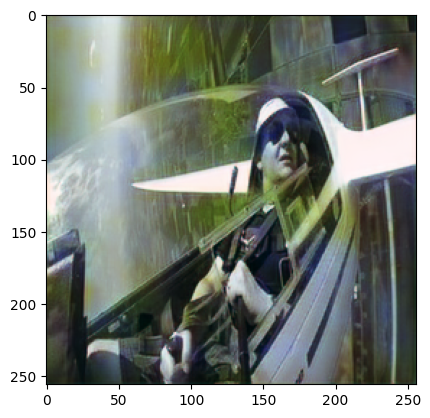

In [20]:
# input_1 = frames_dataset[99][0].to(device).unsqueeze(0)
# input_2 = frames_dataset[101][0].to(device).unsqueeze(0)
data = vid_dataset[10]
input_ = torch.cat((data[0].unsqueeze(0).cuda() * 0.5, data[1].unsqueeze(0).cuda()), dim = 1)
output = model(input_)
output = prep_output(output.cuda(), data[1].unsqueeze(0).cuda())
print(output.shape)

output_img = frames_dataset.lab_to_rgb(output.detach()[0].cpu())
print(output_img.shape)
plt.imshow(output_img.permute(1, 2, 0))

Showing 16 samples from training set torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])


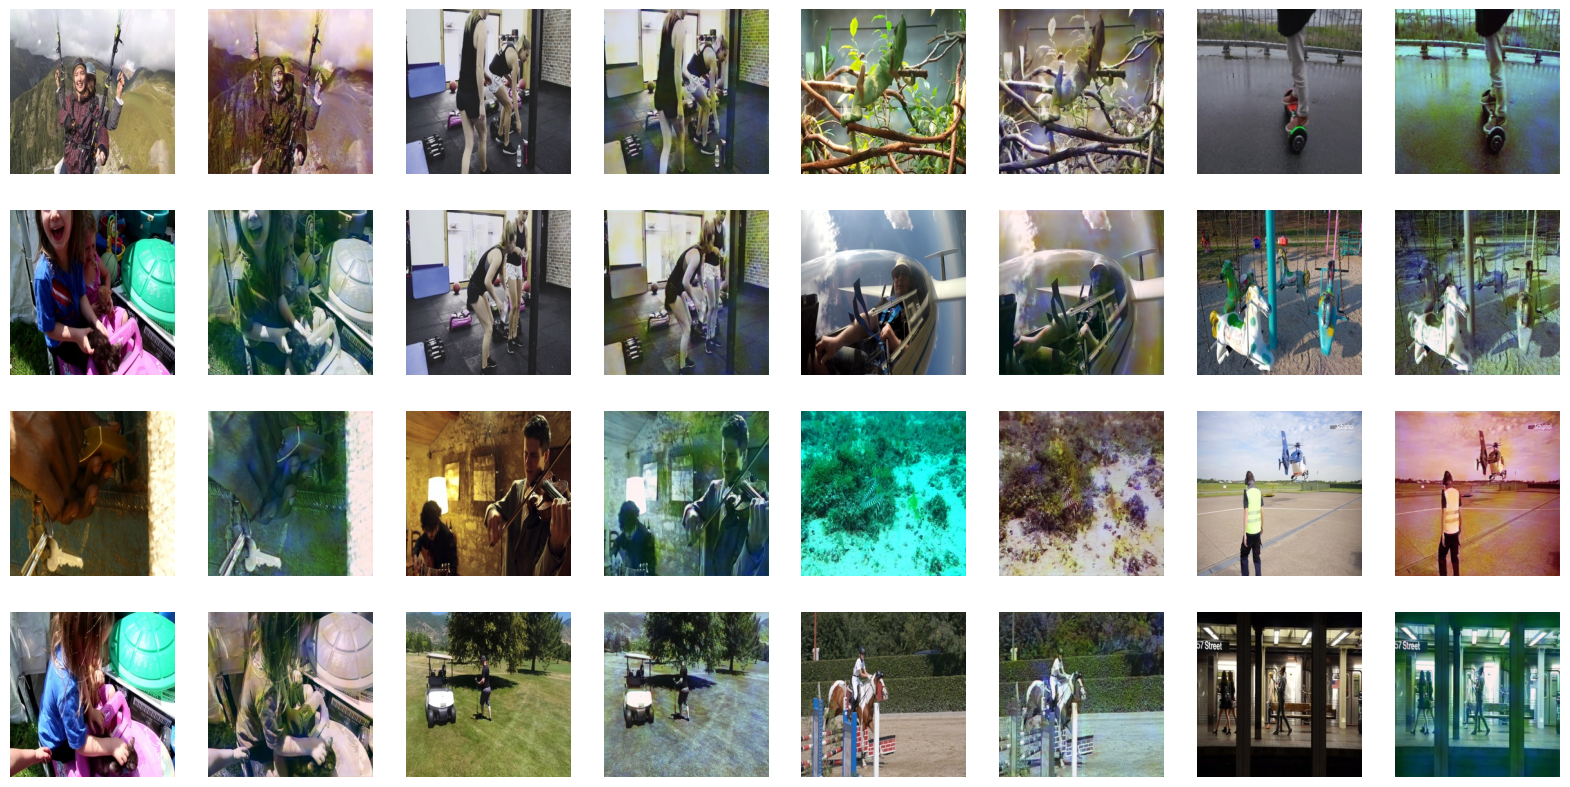

In [21]:
# vqa_dataset_images
plt.figure(figsize=(20, 10))
for prev_x, x, prev_y, y in vid_loader:
    prev_x: torch.Tensor
    prev_y: torch.Tensor
    x: torch.Tensor
    y: torch.Tensor
    n = min(x.shape[0], 16)
    print(f"Showing {n} samples from training set", x.shape, y.shape)
    for i in range(n):
        # x: input, grayscale
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(Places365Train.lab_to_rgb(y[i]).permute(1, 2, 0))
        plt.axis("off")
        # y: ground truth
        plt.subplot(4, 8, i * 2 + 2)
        
        input1 = x[i].to(device).unsqueeze(0)
        input2 = prev_x[i].to(device).unsqueeze(0)
        input_ = torch.cat((input2 * 0.5, input1), dim=1)
        output = model(input_)
        output_img = prep_output(output.cuda(), input1.cuda())
        #output_img = model.convert_output_to_rgb(input1[0].cpu(), output.detach()[0].cpu())
        plt.imshow(output_img.detach().squeeze(0).permute(1, 2, 0).cpu())
        plt.axis("off")
    break

In [27]:
import os
import cv2
import torch
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
output_dir = "output_video"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set the model to evaluation mode
model.eval()
output_images = []
prev_output = None

with torch.no_grad():  # Disable gradient calculation for testing
    for vid_idx in range(len(vid_dataset)):
        prev_x, x, prev_y, y = vid_dataset[vid_idx]
        prev_x, x, prev_y, y = prev_x.to(device), x.to(device), prev_y.to(device), y.to(device)

        # Concatenate prev_frame and x
        #prev_x = prev_x if prev_output is None else prev_output.squeeze(0)
        input_tensor = torch.cat((prev_x, x), dim=0).unsqueeze(0)  # Shape: (1, 6, H, W)
        input_tensor = input_tensor.to(device)

        # Forward pass through the model
        output = model(input_tensor)
        output = prep_output(output, x.unsqueeze(0))
        
        if prev_output is not None:
            output[:, 1:3, ...] = prev_output[:, 1:3, ...] * 0.5 + output[:, 1:3, ...] * 0.5
        
        prev_output = output.detach()
        output_img = frames_dataset.lab_to_rgb(output.detach()[0].cpu())
        output_img_np = output_img.permute(1, 2, 0).numpy()

        # Convert the image to a format suitable for OpenCV
        output_img_np = (output_img_np * 255).astype('uint8')
        output_images.append(output_img_np)

    # Save the frames as a video file
    video_filename = os.path.join(output_dir, f"video.mp4")
    height, width, _ = output_images[0].shape
    video_writer = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

    for img in output_images:
        video_writer.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR for OpenCV

    video_writer.release()
    print(f"Saved video to {video_filename}")

Saved video to output_video/video.mp4


# Pruning

In [ ]:
def get_all_layers(model):
    layers = []

    def _get_layers_recursive(module):
        if not list(module.children()):
            layers.append(module)
        else:
            for child in module.children():
                _get_layers_recursive(child)
    _get_layers_recursive(model)
    return layers

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

def get_next_conv_layer(layers, k):
    for i in range(k+1,len(layers)):
        if isinstance(layers[i], nn.Conv2d) and layers[k].weight.shape[1] == layers[i].weight.shape[0]:
            
            return i
    return -1

def get_prev_conv_layer(layers, k):
    for i in reverse(range(0,k)):
        if isinstance(layers[i], nn.Conv2d):
            return i
    return -1

def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    return int(round(channels*(1-prune_ratio)))

def find_index(layers, target):
    for i, layer in enumerate(layers):
        if layer == target:
            return i
def get_out_channel_importance(weight):
    out_channels = weight.shape[0]
    importances = []
    # compute the importance for each input channel
    for o_c in range(weight.shape[0]):
        channel_weight = weight.detach()[o_c]
        importance = torch.linalg.norm(channel_weight)
        importances.append(importance.view(1))
    return torch.cat(importances)
def get_keep_indices(conv_layer, p_ratio):
    n_keep = get_num_channels_to_keep(conv_layer.out_channels, p_ratio)
    importance = get_out_channel_importance(conv_layer.weight)
    sort_idx = torch.argsort(importance, descending=True)
    return sort_idx[:n_keep]

In [ ]:
import copy
model = ConvNetWithEfficientNetFeatureExtractor()
model.load_state_dict(torch.load("/kaggle/working/model.pth"))
model2 = copy.deepcopy(model)

model2 = model2.to("cpu")
model2.eval()
layers = get_all_layers(model2.feature_extractor)
print("copied")

In [ ]:
prune_type_1 = []
prune_type_2 = []
prune_type_3 = []
prune_type_4 = []


for i in range(len(layers)-2):
    if isinstance(layers[i], nn.Conv2d) and isinstance(layers[i+1], nn.BatchNorm2d):
        if isinstance(layers[i+2], nn.SiLU):
            prune_type_1.append(i)
        else:
            prune_type_2.append(i)
    if isinstance(layers[i], nn.Conv2d) and isinstance(layers[i+1],nn.Conv2d):
        prune_type_3.append(i)
        prune_type_4.append(i+1)

print(len(prune_type_1), len(prune_type_2), len(prune_type_3),  len(prune_type_4))

In [ ]:
conv_layer = model2.colorization_layers[1].conv
bn_layer =  model2.colorization_layers[1].bn
next_conv_layer =  model2.colorization_layers[2].conv

In [ ]:
p_ratio = 0.3
n_keep = get_num_channels_to_keep(conv_layer.out_channels, p_ratio)
keep_idx = get_keep_indices(conv_layer, p_ratio)

with torch.no_grad():
    bn_layer.weight.set_(bn_layer.weight.detach()[keep_idx])
    bn_layer.bias.set_(bn_layer.bias.detach()[keep_idx])
    bn_layer.running_mean.set_(bn_layer.running_mean.detach()[keep_idx])
    bn_layer.running_var.set_(bn_layer.running_var.detach()[keep_idx])

    conv_layer.out_channels = n_keep
    conv_layer.weight.set_(conv_layer.weight.detach()[keep_idx])

    if conv_layer.bias is not None:
        conv_layer.bias.set_(conv_layer.bias.detach()[keep_idx])

    if next_conv_layer.groups > 1:
        next_conv_layer.groups = n_keep

    next_conv_layer.in_channels = n_keep
    next_conv_layer.weight.set_(next_conv_layer.weight.detach()[:,keep_idx,:,:])

get_num_parameters(model2)/get_num_parameters(model)

In [ ]:
model2.feature_extractor[8] = nn.Identity()
model2.colorization_layers[0] = nn.Identity()

get_num_parameters(model2)/get_num_parameters(model)

In [ ]:
p_ratio = 0.5
for i in prune_type_3:
    conv_layer = layers[i]    
    next_conv_layer = layers[i+1]

    n_keep = get_num_channels_to_keep(conv_layer.out_channels, p_ratio)
    keep_idx = get_keep_indices(conv_layer, p_ratio)
    
    conv_layer.out_channels = n_keep
    conv_layer.weight.set_(conv_layer.weight.detach()[keep_idx])
    
    if conv_layer.bias is not None:
        conv_layer.bias.set_(conv_layer.bias.detach()[keep_idx])

    next_conv_layer.weight.set_(next_conv_layer.weight.detach()[:,keep_idx,:,:])
    if next_conv_layer.groups > 1:
        next_conv_layer.groups = n_keep
    next_conv_layer.in_channels = n_keep
    
get_num_parameters(model2)/get_num_parameters(model)

# VQA dataset - unpruned

In [ ]:
model = model.to(device)

video_frames, bw_frames = vid_dataset[1]
video_frames = video_frames.to(device)
bw_frames = bw_frames.to(device)
# lab_frames = lab_frames.to(device)

plt.figure(figsize=(20, 10))

model.eval()  # Set the model to evaluation mode

prev_output = None

with torch.no_grad():  # Disable gradient calculation for testing
    for i in range(16):
        y = video_frames[i]
        prev_frame = prev_output if prev_output is not None else bw_frames[0]        # 3D tensor
        x = bw_frames[i]
        
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(frames_dataset.lab_to_rgb(y).permute(1, 2, 0).cpu())
        plt.axis("off")

        # Concatenate prev_frame and x
        input_tensor = torch.cat((prev_frame, x), dim=0).unsqueeze(0)  # Shape: (1, 6, H, W)
        input_tensor = input_tensor.to(device)

        # Forward pass through the model
        output = model(input_tensor)
        output_img = frames_dataset.lab_to_rgb(output.detach()[0].cpu())
        plt.subplot(4, 8, i * 2 + 2)
        plt.imshow(output_img.permute(1, 2, 0))
        plt.axis("off")

        prev_output = output.detach().squeeze()

# VQA dataset - pruned

In [ ]:
model2 = model2.to(device)

video_frames, bw_frames = vid_dataset[1]
video_frames = video_frames.to(device)
bw_frames = bw_frames.to(device)
# lab_frames = lab_frames.to(device)

plt.figure(figsize=(20, 10))

model.eval()  # Set the model to evaluation mode

prev_output = None

with torch.no_grad():  # Disable gradient calculation for testing
    for i in range(16):
        y = video_frames[i]
        prev_frame = prev_output if prev_output is not None else bw_frames[0]        # 3D tensor
        x = bw_frames[i]
        
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(frames_dataset.lab_to_rgb(y).permute(1, 2, 0).cpu())
        plt.axis("off")

        # Concatenate prev_frame and x
        input_tensor = torch.cat((prev_frame, x), dim=0).unsqueeze(0)  # Shape: (1, 6, H, W)
        input_tensor = input_tensor.to(device)

        # Forward pass through the model
        output = model2(input_tensor)
        output_img = frames_dataset.lab_to_rgb(output.detach()[0].cpu())
        plt.subplot(4, 8, i * 2 + 2)
        plt.imshow(output_img.permute(1, 2, 0))
        plt.axis("off")

        prev_output = output.detach().squeeze()

# Re-train/Fine-tune

In [ ]:
model2.to(device)
model2.requires_grad_= True

optimizer = AdamW(model2.parameters(), lr=1e-5)
mseloss = MSELoss()
weighted_mseloss = WeightedMSELoss(value_embedding)

#val_loader = DataLoader(val_set, batch_size=64)
train(model2, train_loader, val_loader, weighted_mseloss, mseloss, optimizer, device, epochs=1)
# train(model, vid_loader, None, weighted_mseloss, mseloss, optimizer, device, epochs=1)

In [ ]:
torch.save(model2.state_dict(), "/kaggle/working/model_p.pth")

# video dataset - unpruned

In [ ]:
model = model.to(device)

video_frames, bw_frames = vid_dataset[1]
video_frames = video_frames.to(device)
bw_frames = bw_frames.to(device)
# lab_frames = lab_frames.to(device)

plt.figure(figsize=(20, 10))

model.eval()  # Set the model to evaluation mode

prev_output = None

with torch.no_grad():  # Disable gradient calculation for testing
    for i in range(16):
        y = video_frames[i]
        prev_frame = prev_output if prev_output is not None else bw_frames[0]        # 3D tensor
        x = bw_frames[i]
        
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(frames_dataset.lab_to_rgb(y).permute(1, 2, 0).cpu())
        plt.axis("off")

        # Concatenate prev_frame and x
        input_tensor = torch.cat((prev_frame, x), dim=0).unsqueeze(0)  # Shape: (1, 6, H, W)
        input_tensor = input_tensor.to(device)

        # Forward pass through the model
        output = model(input_tensor)
        output_img = frames_dataset.lab_to_rgb(output.detach()[0].cpu())
        plt.subplot(4, 8, i * 2 + 2)
        plt.imshow(output_img.permute(1, 2, 0))
        plt.axis("off")

        prev_output = output.detach().squeeze()

# video dataset - pruned

In [ ]:
model2 = model2.to(device)

video_frames, bw_frames = vid_dataset[1]
video_frames = video_frames.to(device)
bw_frames = bw_frames.to(device)
# lab_frames = lab_frames.to(device)

plt.figure(figsize=(20, 10))

model.eval()  # Set the model to evaluation mode

prev_output = None

with torch.no_grad():  # Disable gradient calculation for testing
    for i in range(16):
        y = video_frames[i]
        prev_frame = prev_output if prev_output is not None else bw_frames[0]        # 3D tensor
        x = bw_frames[i]
        
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(frames_dataset.lab_to_rgb(y).permute(1, 2, 0).cpu())
        plt.axis("off")

        # Concatenate prev_frame and x
        input_tensor = torch.cat((prev_frame, x), dim=0).unsqueeze(0)  # Shape: (1, 6, H, W)
        input_tensor = input_tensor.to(device)

        # Forward pass through the model
        output = model2(input_tensor)
        output_img = frames_dataset.lab_to_rgb(output.detach()[0].cpu())
        plt.subplot(4, 8, i * 2 + 2)
        plt.imshow(output_img.permute(1, 2, 0))
        plt.axis("off")

        prev_output = output.detach().squeeze()

# Apply quantization

In [ ]:
feature32 = model2.feature_extractor[0:2](x) 
feature48 = model2.feature_extractor[2](feature32) 
feature80 = model2.feature_extractor[3](feature48) 
feature224 = model2.feature_extractor[4:6](feature80)
feature640 = model2.feature_extractor[6:8](feature224)
feature2560 = model2.feature_extractor[8](feature640)

In [ ]:
import torch
from torch import nn
import copy

backend = "fbgemm"
m = copy.deepcopy(model2).to("cpu")
m.eval()
ITERATIONS = 5

In [ ]:
def get_quantized(layer, sample_input):
    q = nn.Sequential(torch.quantization.QuantStub(), 
                  layer, 
                  torch.quantization.DeQuantStub())
    q.qconfig = torch.quantization.get_default_qconfig(backend)
    torch.quantization.prepare(q, inplace=True)

    with torch.inference_mode():
        for _ in range(ITERATIONS):
            out = q(sample_input)
    torch.quantization.convert(q, inplace=True)
    return q, out

In [ ]:
q0, out = get_quantized(m.colorization_layers[0],feature2560)
q1, out = get_quantized(m.colorization_layers[1:3],feature640+out)
q2, out = get_quantized(m.colorization_layers[3:5],feature224+out)
q3, out = get_quantized(m.colorization_layers[5],feature80+out)
q4, out = get_quantized(m.colorization_layers[6],feature48+out)
q5, out = get_quantized(m.colorization_layers[7:10],feature32+out)

In [ ]:
vid_loader = DataLoader(vid_dataset, batch_size=1)
for frames, bw_frames, lab_frames in tqdm(vid_loader):
    x = torch.cat((bw_frames[: , 0], bw_frames[: , 1]), dim=1)
    print(x.shape)
    break

In [ ]:
model2.colorization_layers = nn.Sequential(q0,q1,q2,q3,q4,q5)
model2.quantized = True

In [ ]:
torch.save(model2.state_dict(), "/kaggle/working/model_pq.pth")